# Quantitative Risk Management - Final Exam

## Import Libraries

In [1]:

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import metrics

# Options
pd.set_option('display.max_columns', None)

## Load Data

In [2]:
# Load data
file_path = 'data/bankrupt_us.csv'
df = pd.read_csv(file_path)

# Print shape
print(df.shape)

(78682, 21)


In [3]:
# Display first 5 rows
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## Exploratory Data Analysis (EDA) and Preprocessing

### Rename Columns

In [ ]:
# Renamme columns
df.rename(columns={'X1':'current_assets',
                     'X2':'cost_of_goods_sold',
                     'X3':'depreciation_and_amortization',
                     'X4':'ebitda',
                     'X5':'inventory',
                     'X6':'net_income',
                     'X7':'total_receivables',
                     'X8':'market_value',
                     'X9':'net_sales',
                     'X10':'total_assets',
                     'X11':'total_long_term_debt',
                     'X12':'ebit',
                     'X13':'gross_profit',
                     'X14':'total_current_liabilities',
                     'X15':'retained_earnings',
                     'X16':'total_revenue',
                     'X17':'total_liabilities',
                     'X18':'total_operating_expenses'},
                     inplace=True)

### Transform Targe Variable

In [5]:
# 0 for alive and 1 for bankrupt
df['status_label'] = df['status_label'].apply(lambda x: 0 if x == 'alive' else 1)

### Create New Features

In [6]:
df_new = df.copy()

# Liquidity & Solvency Ratios
df_new['current_ratio'] = df_new['current_assets'] / df_new['total_current_liabilities']  # Current Ratio
df_new['quick_ratio'] = (df_new['current_assets'] - df_new['inventory']) / df_new['total_current_liabilities']  # Quick Ratio
df_new['cash_ratio'] = (df_new['current_assets'] - df_new['total_receivables'] - df_new['inventory']) / df_new['total_current_liabilities']  # Cash Ratio
df_new['working_capital'] = df_new['current_assets'] - df_new['total_current_liabilities']  # Working Capital
df_new['working_capital_to_assets'] = df_new['working_capital'] / df_new['total_assets']  # Working Capital to Assets

# Profitability Ratios
df_new['gross_profit_margin'] = df_new['gross_profit'] / df_new['total_revenue']  # Gross Profit Margin (GPM)
df_new['net_profit_margin'] = df_new['net_income'] / df_new['total_revenue']  # Net Profit Margin (NPM)
df_new['ebit_margin'] = df_new['ebit'] / df_new['total_revenue']  # EBIT Margin
df_new['ebitda_margin'] = df_new['ebitda'] / df_new['total_revenue']  # EBITDA Margin
df_new['return_on_assets'] = df_new['net_income'] / df_new['total_assets']  # Return on Assets (ROA)
df_new['return_on_sales'] = df_new['ebit'] / df_new['total_revenue']  # Return on Sales (ROS)

# Leverage Ratios
df_new['debt_to_assets'] = df_new['total_liabilities'] / df_new['total_assets']  # Debt to Assets
df_new['long_term_debt_to_assets'] = df_new['total_long_term_debt'] / df_new['total_assets']
df_new['debt_to_liabilities'] = df_new['total_long_term_debt'] / df_new['total_liabilities']  # Debt to Liabilities
df_new['liabilities_to_assets'] = df_new['total_liabilities'] / df_new['total_assets']  # Liabilities to Assets

# Efficiency Ratios
df_new['asset_turnover'] = df_new['total_revenue'] / df_new['total_assets']  # Asset Turnover

# Altman Z-Score
df_new['z_score'] = (
    1.2 * (df_new['working_capital'] / df_new['total_assets']) +
    1.4 * (df_new['retained_earnings'] / df_new['total_assets']) +
    3.3 * (df_new['ebit'] / df_new['total_assets']) +
    0.6 * (df_new['market_value'] / df_new['total_liabilities']) +
    1 * (df_new['total_revenue'] / df_new['total_assets'])
)

In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   company_name                   78682 non-null  object 
 1   status_label                   78682 non-null  int64  
 2   year                           78682 non-null  int64  
 3   current_assets                 78682 non-null  float64
 4   cost_of_goods_sold             78682 non-null  float64
 5   depreciation_and_amortization  78682 non-null  float64
 6   ebitda                         78682 non-null  float64
 7   inventory                      78682 non-null  float64
 8   net_income                     78682 non-null  float64
 9   total_receivables              78682 non-null  float64
 10  market_value                   78682 non-null  float64
 11  net_sales                      78682 non-null  float64
 12  total_assets                   78682 non-null 

In [8]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
status_label,78682.0,0.066343,0.248882,0.000000,0.000000,0.000000,0.000000,1.000000e+00
year,78682.0,2007.506317,5.742768,1999.000000,2002.000000,2007.000000,2012.000000,2.018000e+03
current_assets,78682.0,880.362485,3928.564794,-7.760000,18.924000,100.449500,431.526750,1.696620e+05
cost_of_goods_sold,78682.0,1594.529029,8930.484664,-366.645000,17.038250,103.661000,634.548000,3.746230e+05
depreciation_and_amortization,78682.0,121.234256,652.376804,0.000000,1.192000,7.929500,47.971750,2.843000e+04
ebitda,78682.0,376.759424,2012.023142,-21913.000000,-0.811000,15.034500,139.655250,8.173000e+04
inventory,78682.0,201.605717,1060.766096,0.000000,0.000000,7.023000,74.747250,6.256700e+04
net_income,78682.0,129.382453,1265.532022,-98696.000000,-7.415750,1.616000,40.144250,1.048210e+05
total_receivables,78682.0,286.832743,1335.978571,-0.006000,3.281250,22.820000,131.580500,6.581200e+04
market_value,78682.0,3414.354610,18414.103647,0.000100,34.980000,227.511850,1244.889950,1.073391e+06


In [9]:
print("Number of unique companies: ", df_new["company_name"].nunique())
print("\nNumber of unique status labels: ", df_new["status_label"].nunique())
print("Status labels: ", df_new['status_label'].unique())

Number of unique companies:  8971

Number of unique status labels:  2
Status labels:  [0 1]


- The dataset contains information for 8971 companies.

- It also contains 2 unique values for the status label: alive (not bankrupt) and failed (bankrupt). This is the target/dependent varibale.

### Missing Values

In [10]:
df_new.isnull().sum()

company_name                     0
status_label                     0
year                             0
current_assets                   0
cost_of_goods_sold               0
depreciation_and_amortization    0
ebitda                           0
inventory                        0
net_income                       0
total_receivables                0
market_value                     0
net_sales                        0
total_assets                     0
total_long_term_debt             0
ebit                             0
gross_profit                     0
total_current_liabilities        0
retained_earnings                0
total_revenue                    0
total_liabilities                0
total_operating_expenses         0
working_capital                  0
current_ratio                    0
quick_ratio                      0
cash_ratio                       0
working_capital_to_assets        0
gross_profit_margin              0
net_profit_margin                0
ebit_margin         

In [11]:
# List of features with missing values
features_with_na = [feature for feature in df_new.columns if df_new[feature].isnull().sum() > 0]

# Print the feature name and the percentage of missing values
for feature in features_with_na:
    print(feature, np.round(df_new[feature].isnull().mean(), 4),  ' % missing values')

The dataset does not contain any missing values.

### Numerical Variables

In [12]:
# List of numerical variables
numerical_features = [feature for feature in df_new.columns if df_new[feature].dtypes != object]
print("Number of numerical variables: ", len(numerical_features))

# Show numerical variables
df_new[numerical_features].head()

Number of numerical variables:  37


,status_label,year,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses,working_capital,current_ratio,quick_ratio,cash_ratio,working_capital_to_assets,gross_profit_margin,net_profit_margin,ebit_margin,ebitda_margin,return_on_assets,return_on_sales,debt_to_assets,long_term_debt_to_assets,debt_to_liabilities,liabilities_to_assets,asset_turnover,z_score
0,0,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,347.451,3.120983,1.069792,0.286303,0.468896,0.186683,0.034328,0.068980,0.086916,0.047454,0.068980,0.541814,0.243519,0.449451,0.541814,1.382369,3.196587
1,0,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,377.1180,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888,360.464,3.874697,1.317995,0.399380,0.513588,0.183521,0.021196,0.052376,0.073625,0.026403,0.052376,0.515267,0.256445,0.497694,0.515267,1.245637,3.109968
2,0,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,364.5928,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514,286.192,2.902063,0.997368,0.482109,0.402974,0.175732,-0.092277,0.007376,0.042596,-0.082989,0.007376,0.563172,0.306532,0.544296,0.563172,0.899355,2.226949
3,0,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,143.3295,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592,192.837,1.947253,0.670308,0.344522,0.280849,0.180741,-0.020467,0.005893,0.050706,-0.018074,0.005893,0.570377,0.239809,0.420440,0.570377,0.883074,1.709901
4,0,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,308.9071,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467,300.943,3.292707,1.409093,0.611743,0.424286,0.197338,0.005375,0.031921,0.072844,0.004940,0.031921,0.574669,0.350583,0.610062,0.574669,0.919167,2.240159


In [13]:
df_new_numeric = df_new.copy()
df_new_numeric.drop(columns=['company_name'], inplace=True)

df_numeric = df.copy()
df_numeric.drop(columns=['company_name'], inplace=True)

#### Year Variables

In [14]:
year_feature = [feature for feature in numerical_features if "year" in feature]
year_feature

['year']

In [15]:
for feature in year_feature:
    print(feature, df_new_numeric[feature].unique())

year [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018]


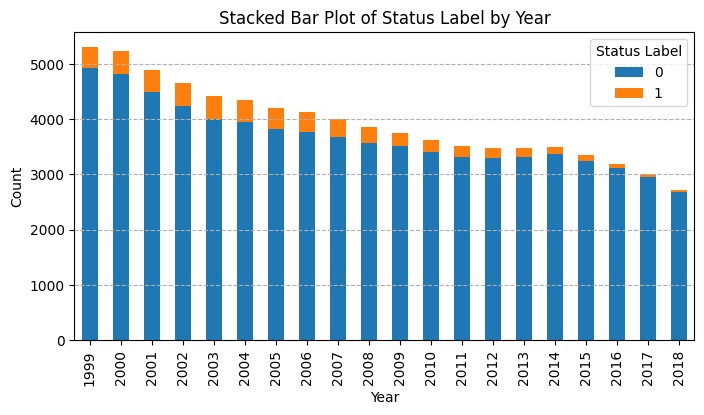

In [16]:
status_counts = df_new_numeric.groupby("year")["status_label"].value_counts().unstack(fill_value=0)
status_counts.plot(kind='bar', stacked=True, figsize=(8, 4))

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Status Label by Year")
plt.legend(title="Status Label", labels=["0", "1"])
plt.grid(axis='y', linestyle='--')

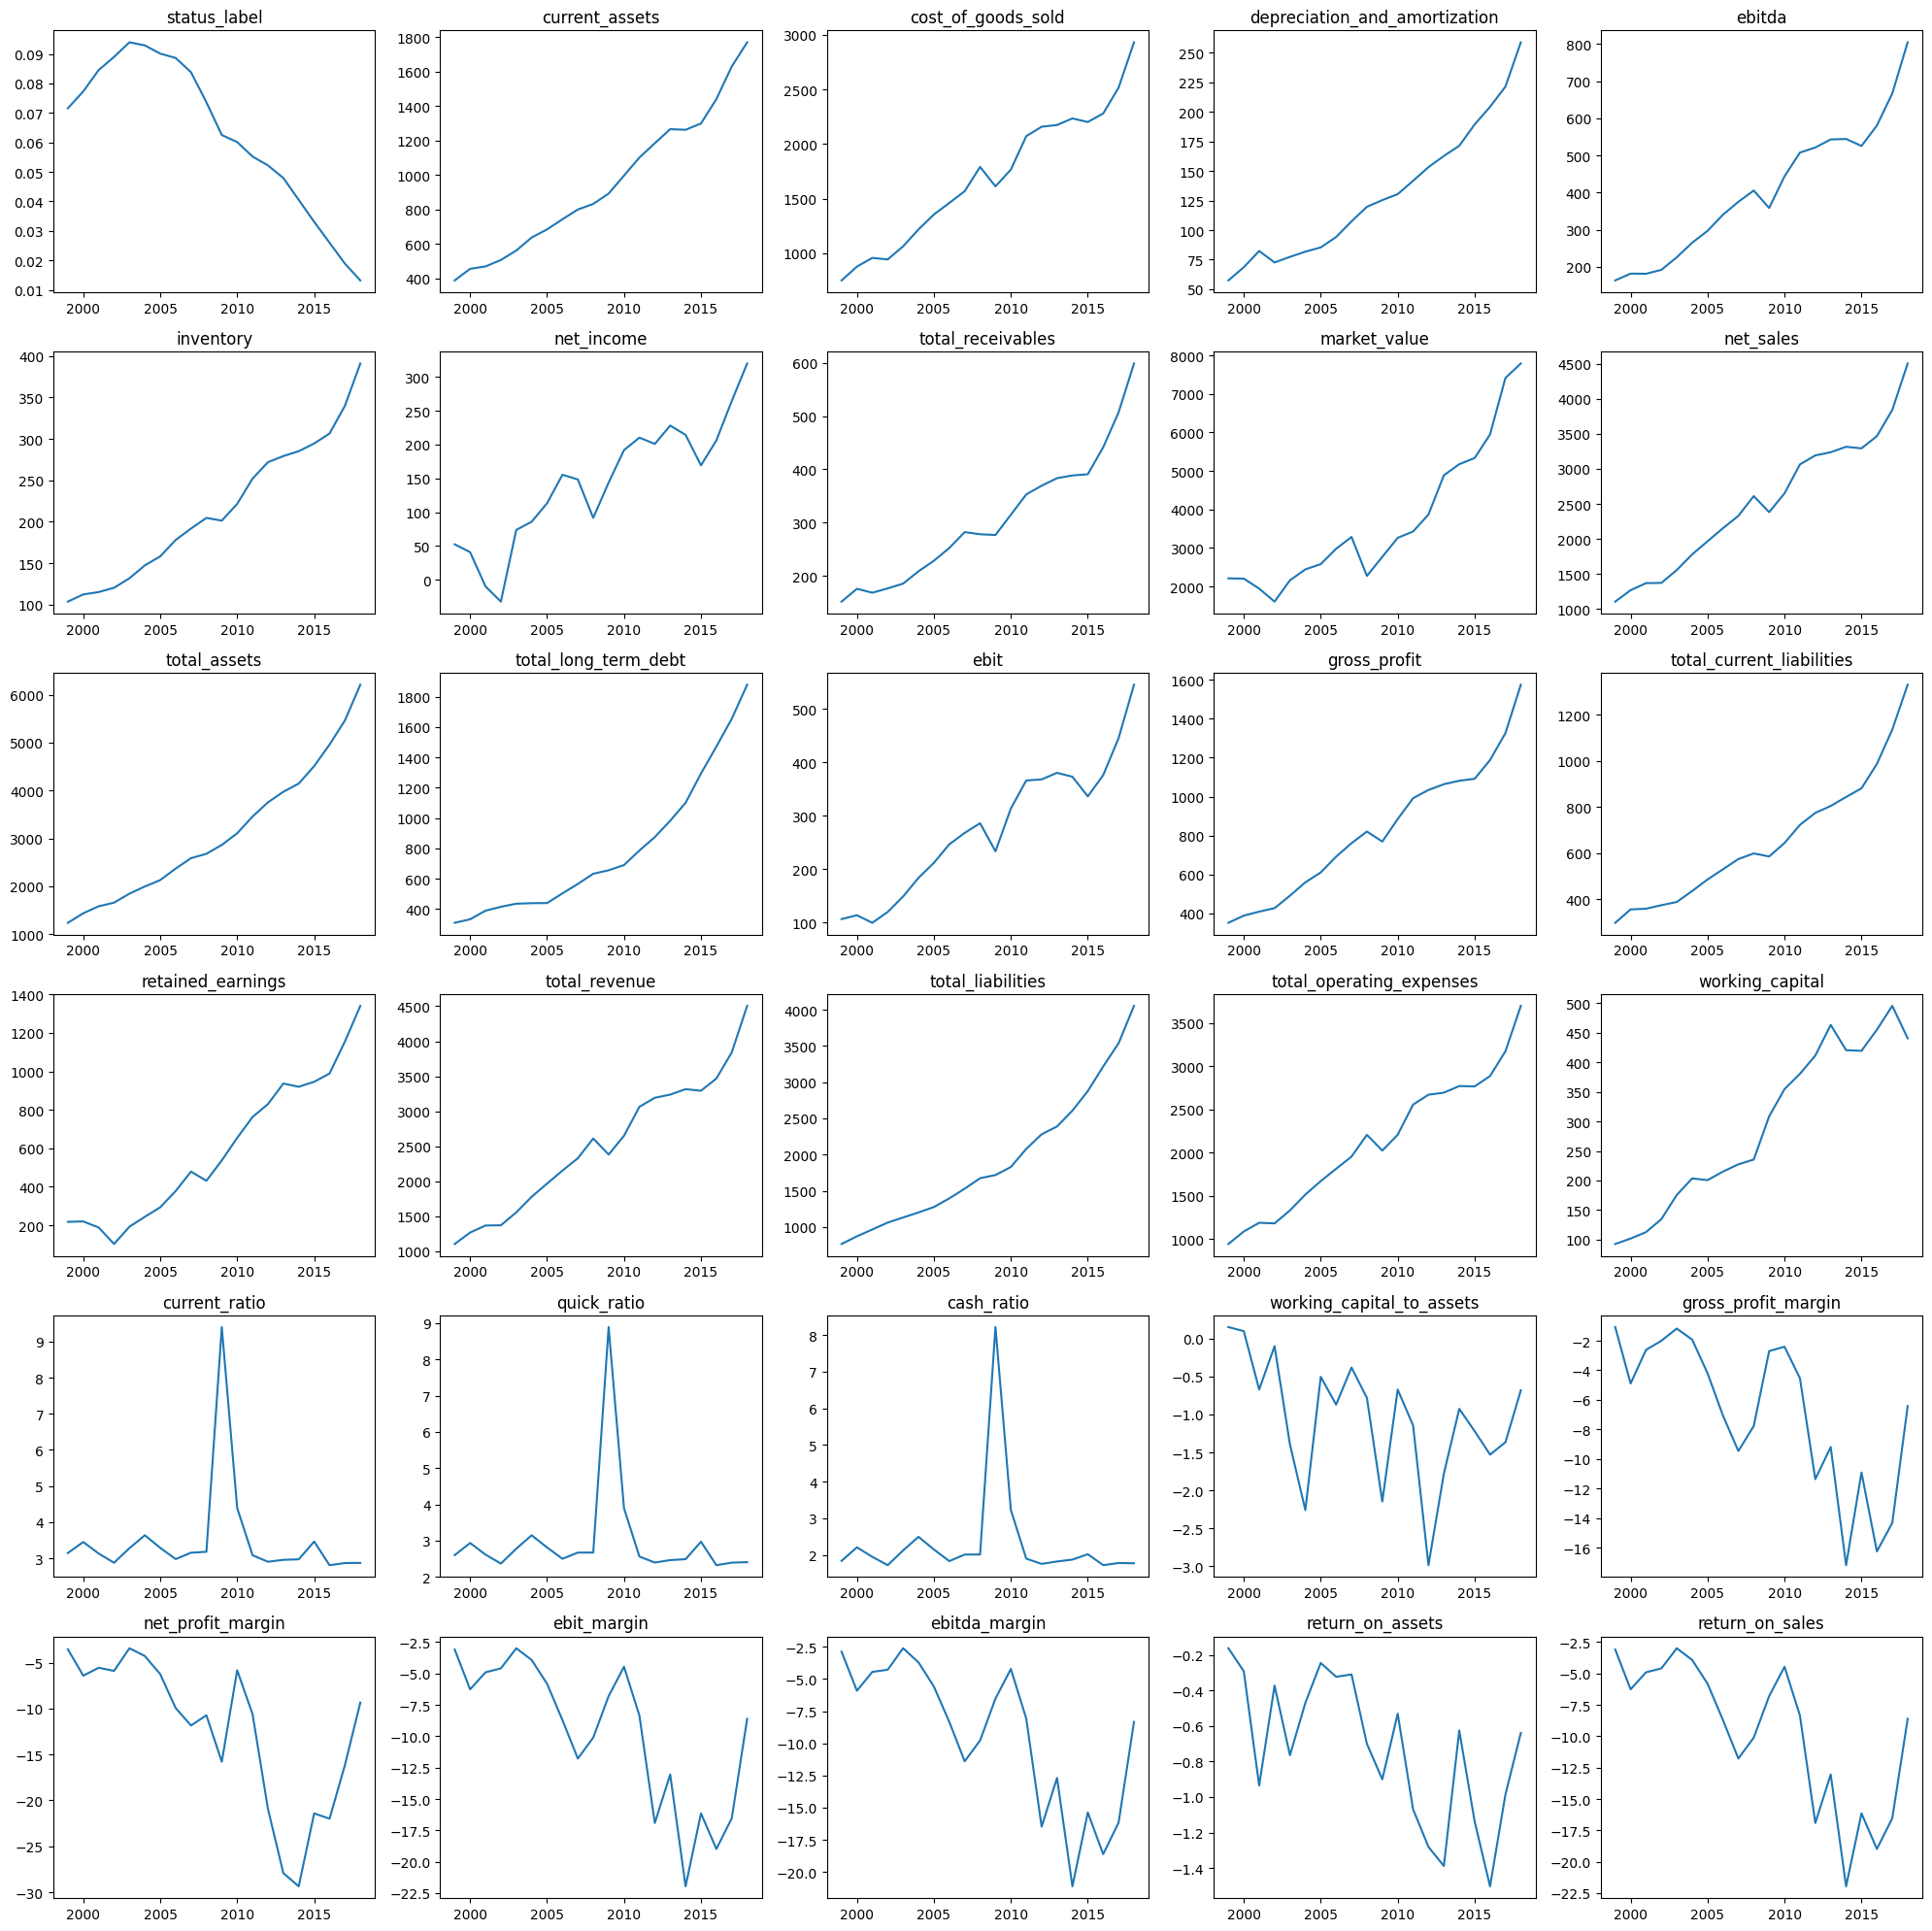

In [17]:
df_means = df_new_numeric.groupby('year').mean()

fig, axes = plt.subplots(6, 5, figsize=(20, 20))
axes_flat = axes.flatten()

for i, feature in enumerate(df_means.columns[:len(axes_flat)]):
    axes_flat[i].plot(df_means.index, df_means[feature])
    axes_flat[i].set_title(feature)

for ax in axes_flat[len(df_means.columns):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

- The feature Status Label decreases until 2004 and then increases from 2005 onwards. This indicates that the number of bankruptcies were increasing until 2004 and decreasing after. Around 2008/2009 the rate at which the feature increases slows down a bit.

- Almost all finacial features show a increase over time, reflecting overall economic growth and business expansion.

- Current ratio has a big spike around 2009.

- Noticable dips/slowdowns/spikes are evident across all profitability features in 2009.
    - The housing bubble in the US started to burst in 2007.
    - The financial crisis reached its peak in 2008 and lead to a economic recession.
    - Therefore it is very likely that the dips in 2009 are a result of the financial crisis.

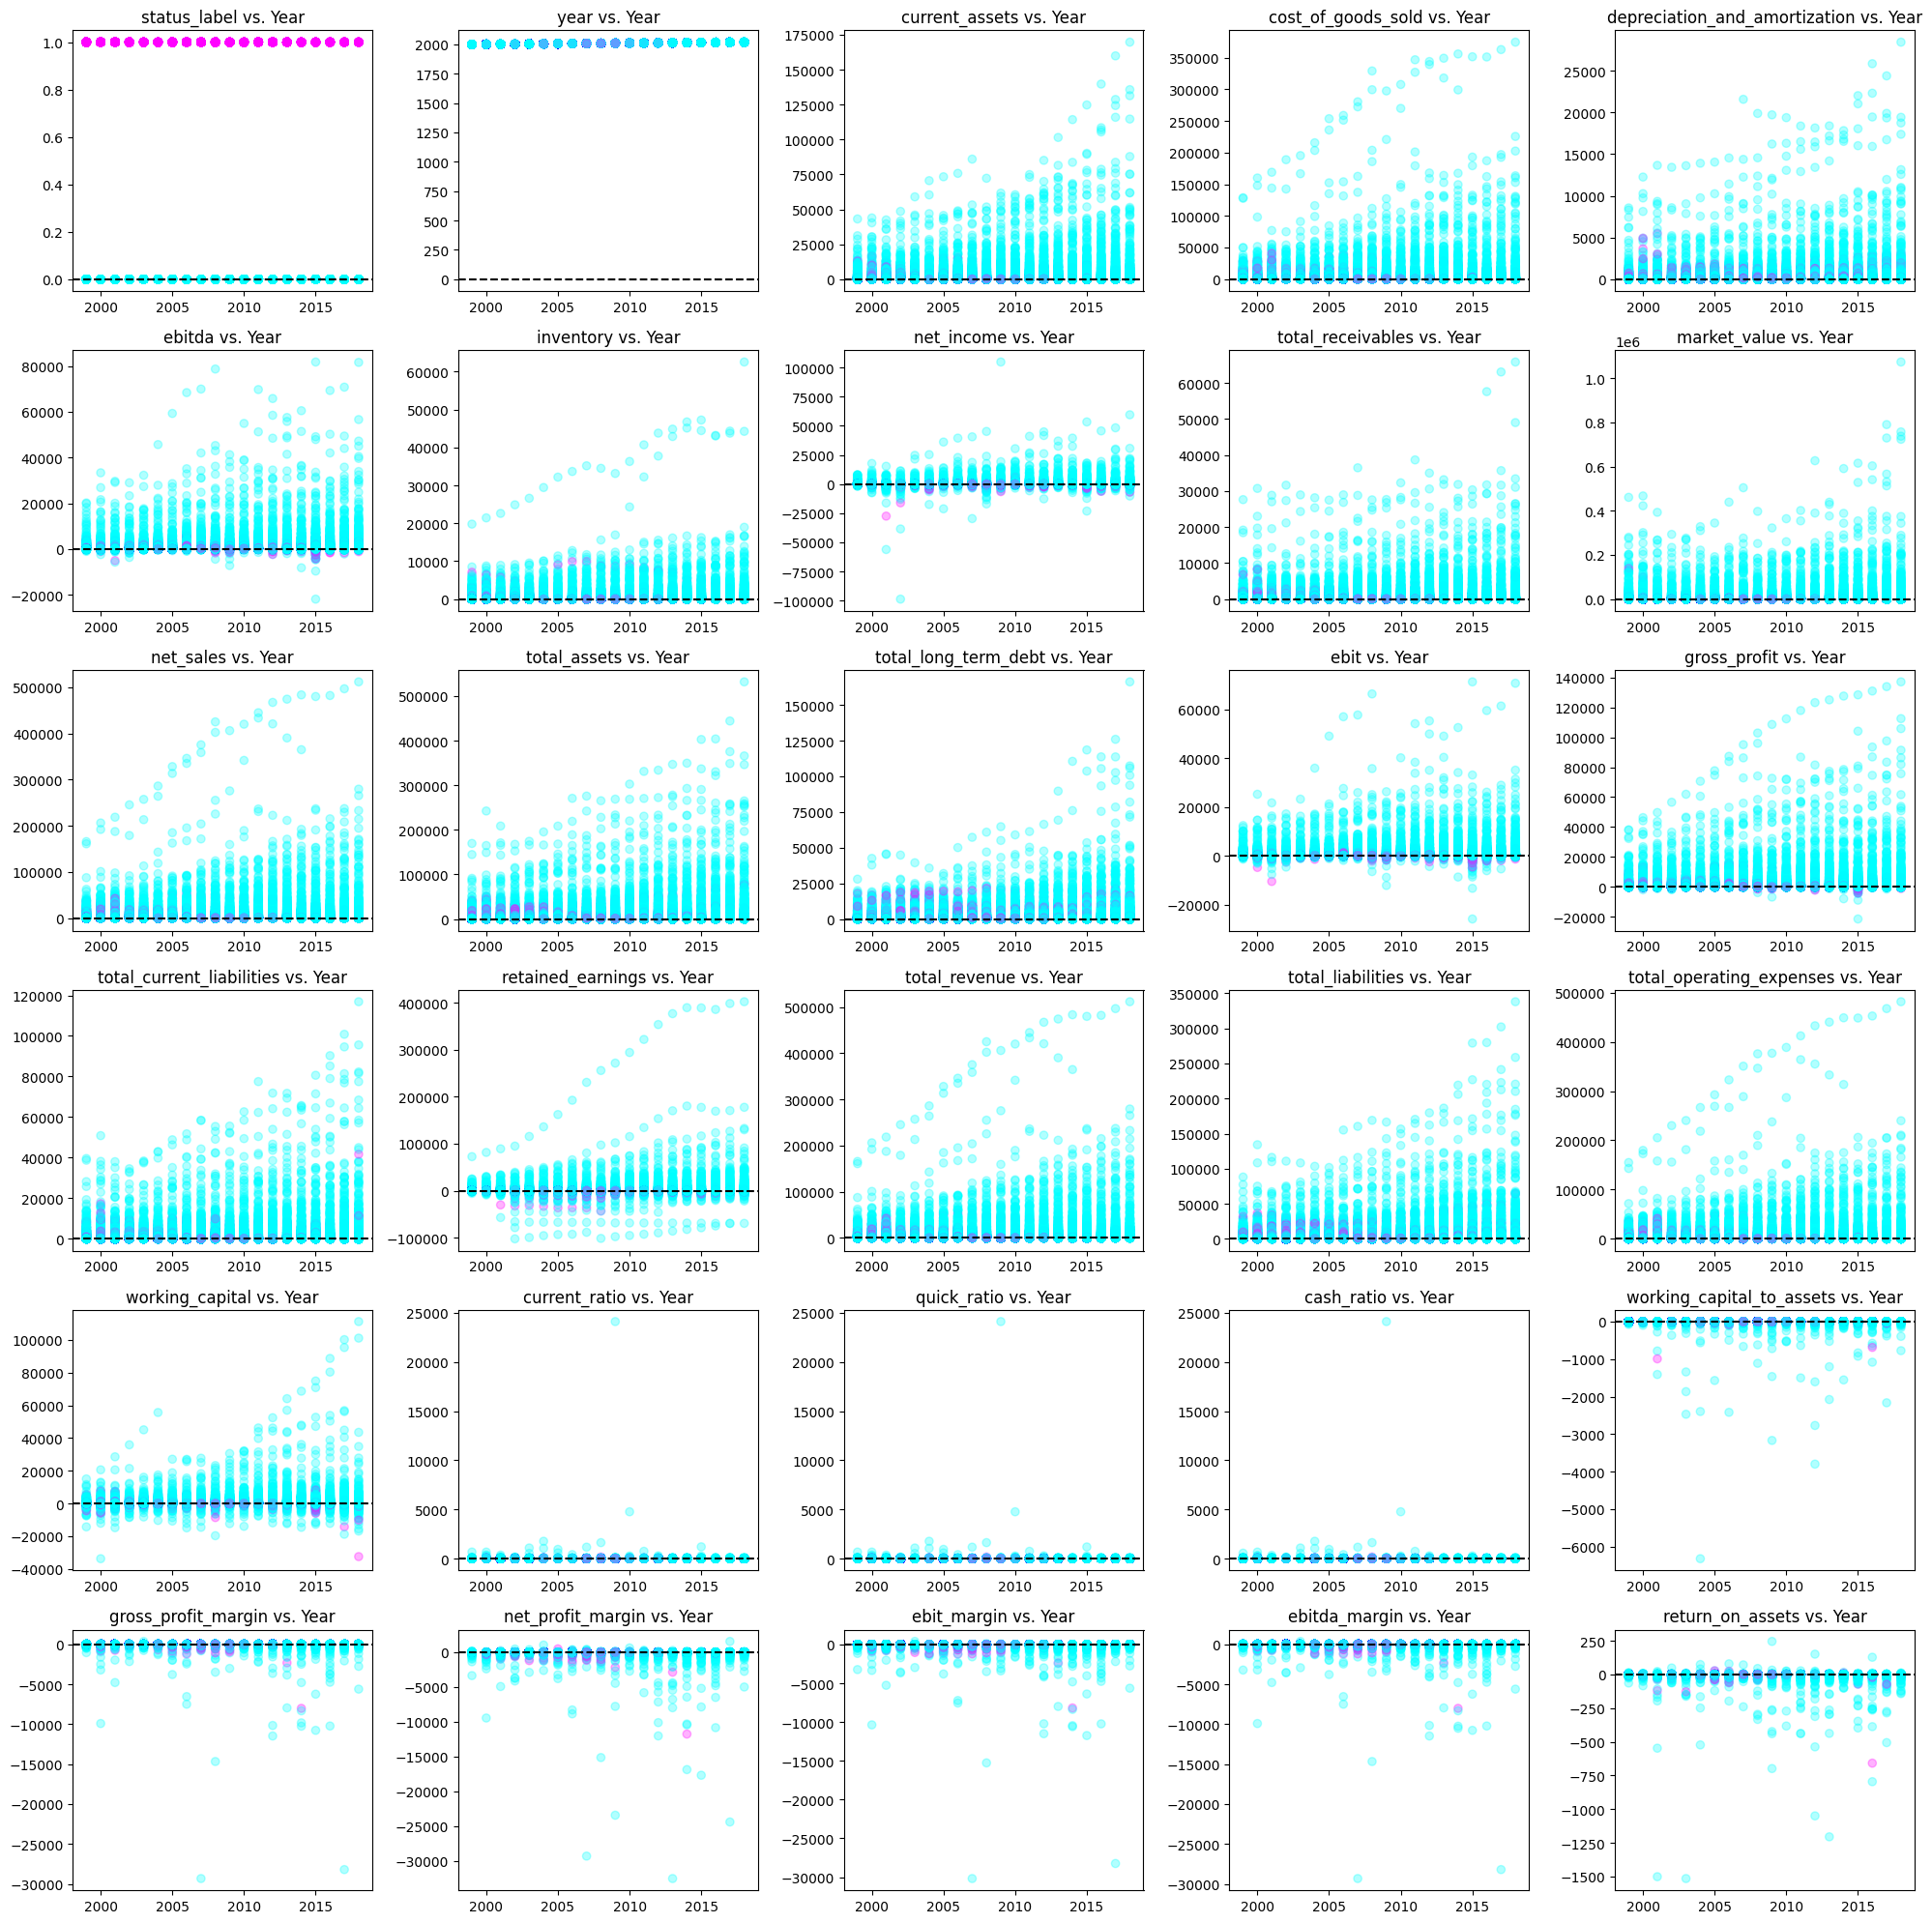

In [18]:
fig, axes = plt.subplots(6, 5, figsize=(20, 20))
axes_flat = axes.flatten()

for i, feature in enumerate(numerical_features[:len(axes_flat)]):
    axes_flat[i].scatter(df_new_numeric['year'], df_new_numeric[feature], c=df_new_numeric['status_label'], cmap='cool', alpha=0.3)
    axes_flat[i].axhline(0, color='black', linestyle='--')
    axes_flat[i].set_title(f"{feature} vs. Year")

for ax in axes_flat[len(numerical_features):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Discrete Variables

In [19]:
discrete_features = [feature for feature in numerical_features if len(df_new_numeric[feature].unique())<25 and feature not in year_feature]
print("Discrete Variables Count: {}".format(len(discrete_features)))
print(discrete_features)

Discrete Variables Count: 1
['status_label']


### Continuous Variables

In [20]:
continuous_features = [feature for feature in numerical_features if feature not in discrete_features and feature not in year_feature] 
print("Continuous Variables Count: {}".format(len(continuous_features)))
print(continuous_features)

Continuous Variables Count: 35
['current_assets', 'cost_of_goods_sold', 'depreciation_and_amortization', 'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value', 'net_sales', 'total_assets', 'total_long_term_debt', 'ebit', 'gross_profit', 'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities', 'total_operating_expenses', 'working_capital', 'current_ratio', 'quick_ratio', 'cash_ratio', 'working_capital_to_assets', 'gross_profit_margin', 'net_profit_margin', 'ebit_margin', 'ebitda_margin', 'return_on_assets', 'return_on_sales', 'debt_to_assets', 'long_term_debt_to_assets', 'debt_to_liabilities', 'liabilities_to_assets', 'asset_turnover', 'z_score']


### Outliers

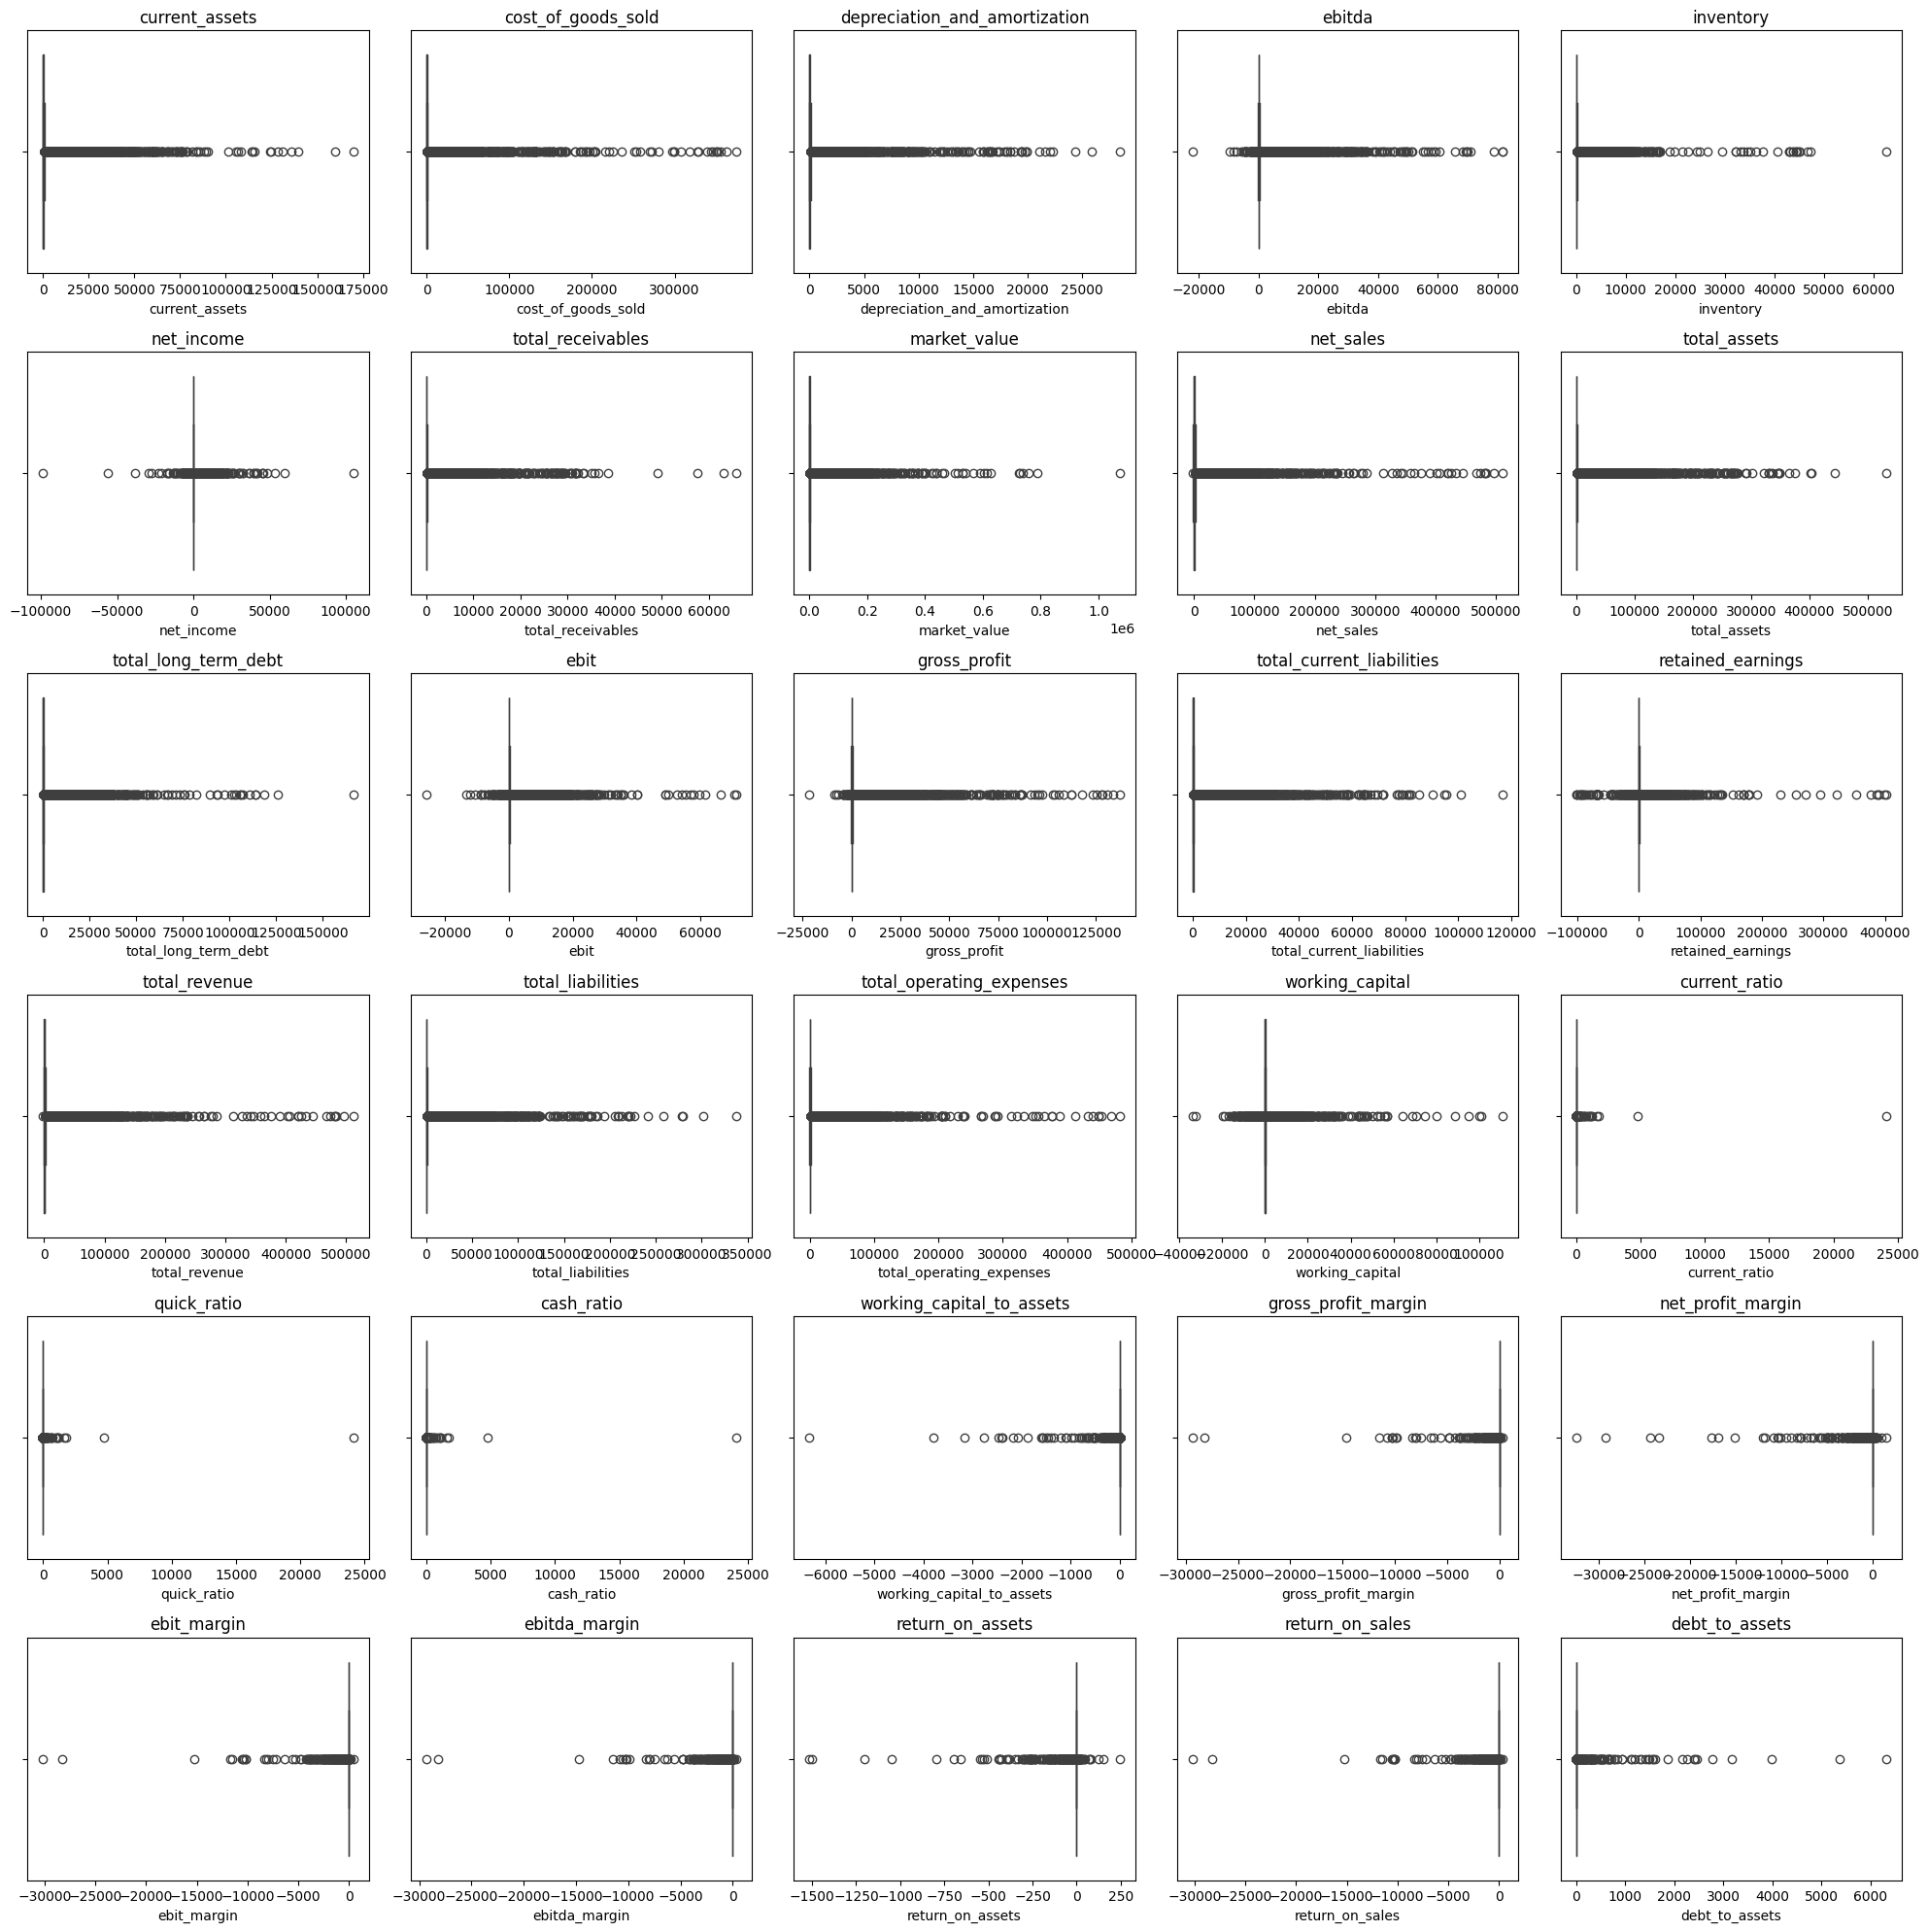

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(20, 20))
axes_flat = axes.flatten()

for i, feature in enumerate(continuous_features[:len(axes_flat)]):
    sns.boxplot(x=df_new_numeric[feature], ax=axes_flat[i])
    axes_flat[i].set_title(feature)

for ax in axes_flat[len(continuous_features):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

- Nearly every variable shows a significant number of outliers at the upper end of the distribution, indicating the presence of highly skewed data.

- Outliers will not be removed because they probably contain important information for bankruptcies.

### Correlation Matrix

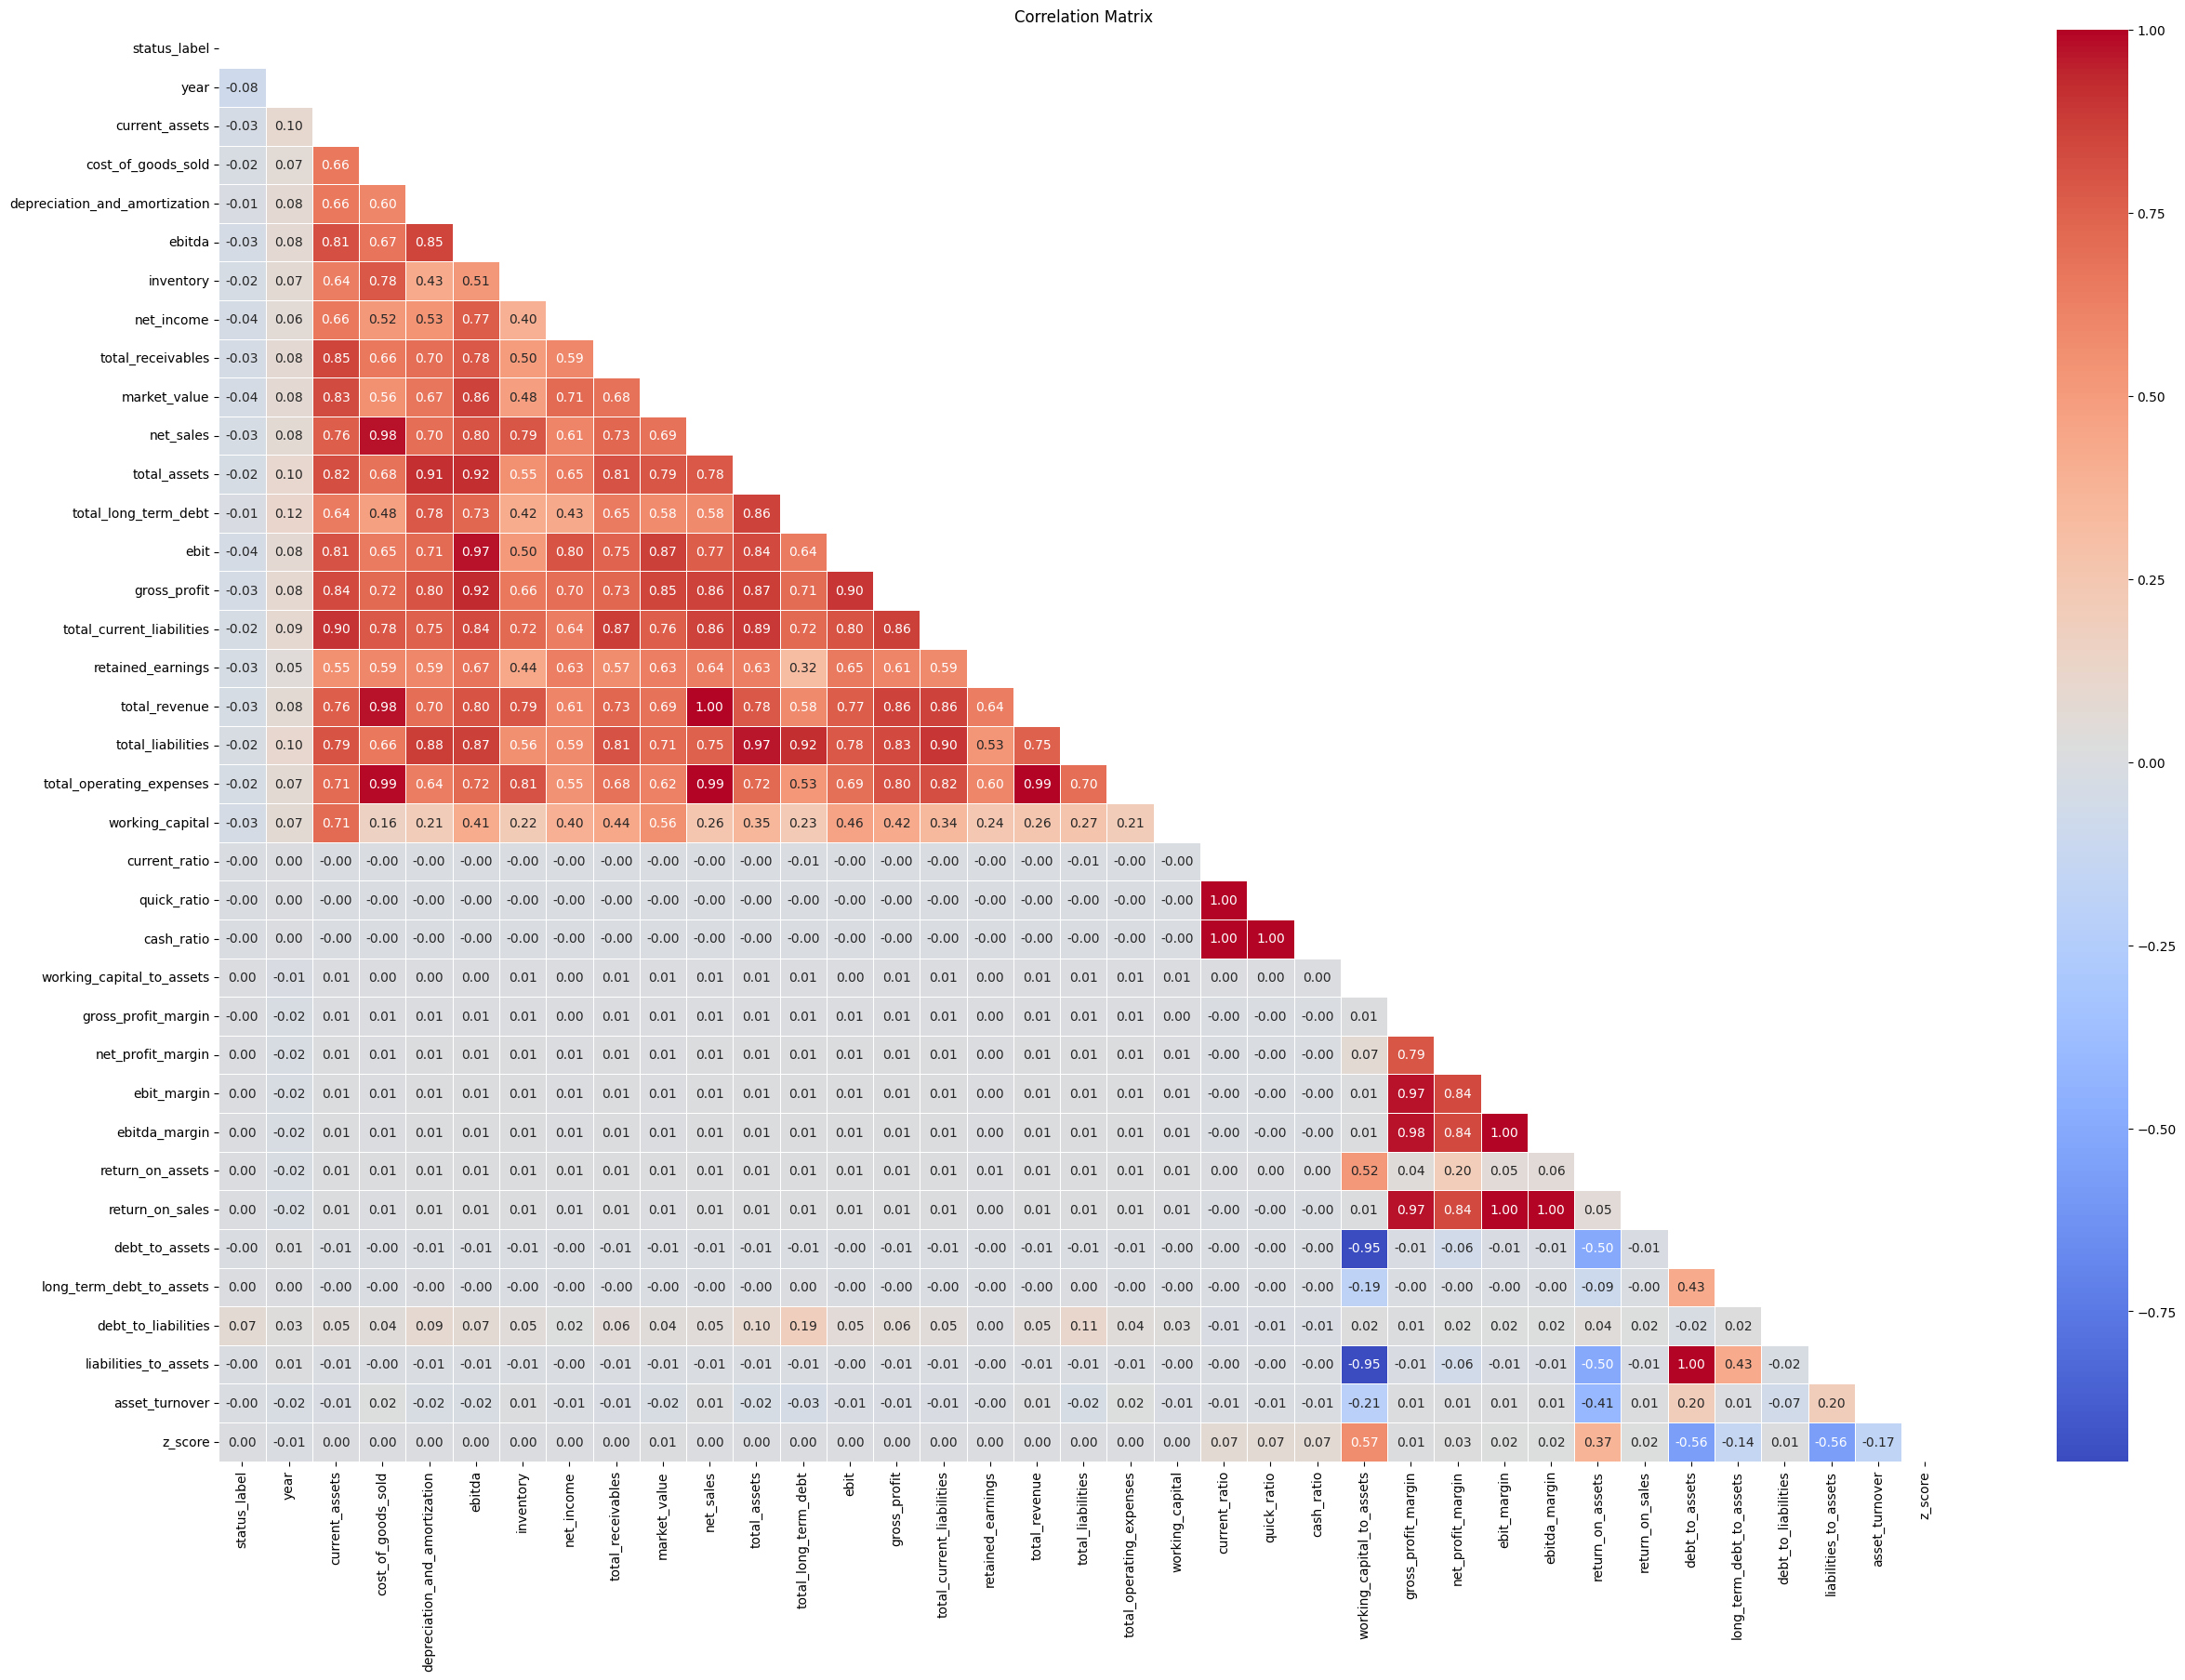

In [22]:
df_corr = df_new_numeric.corr()

mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(30,20))
sns.heatmap(df_corr,
            mask=mask,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            )
plt.title("Correlation Matrix")
plt.show()

### Check Status Change

In [23]:
df_status_change = df_new[df_new.groupby(['company_name'])['status_label'].transform('nunique') > 1]
df_status_change

,company_name,status_label,year,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses,working_capital,current_ratio,quick_ratio,cash_ratio,working_capital_to_assets,gross_profit_margin,net_profit_margin,ebit_margin,ebitda_margin,return_on_assets,return_on_sales,debt_to_assets,long_term_debt_to_assets,debt_to_liabilities,liabilities_to_assets,asset_turnover,z_score


There are no companies with the same name that changed status (i.e alive companies that turned bankrupt or bankrupt companies that started working)

### Drop Duplicates

In [24]:
failed_companies = df_new[df_new['status_label'] == 1]
alive_companies = df_new[df_new['status_label'] == 0].drop_duplicates(subset='company_name')

df_all_companies = pd.concat([alive_companies, failed_companies], ignore_index=True)
df_all_companies.drop(columns=['company_name'],inplace=True)

In [25]:
df_all_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13582 entries, 0 to 13581
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   status_label                   13582 non-null  int64  
 1   year                           13582 non-null  int64  
 2   current_assets                 13582 non-null  float64
 3   cost_of_goods_sold             13582 non-null  float64
 4   depreciation_and_amortization  13582 non-null  float64
 5   ebitda                         13582 non-null  float64
 6   inventory                      13582 non-null  float64
 7   net_income                     13582 non-null  float64
 8   total_receivables              13582 non-null  float64
 9   market_value                   13582 non-null  float64
 10  net_sales                      13582 non-null  float64
 11  total_assets                   13582 non-null  float64
 12  total_long_term_debt           13582 non-null 

### Class Imbalance

In [26]:
df_all_companies.status_label.value_counts(normalize=True)*100

status_label
0    61.56678
1    38.43322
Name: proportion, dtype: float64

The dataset is unbalanced. Therefore I will do SMOTE.

### Data splitting

In [27]:
# Separate features and target
X = df_all_companies.drop('status_label', axis=1)  # Features
y = df_all_companies['status_label'] # Target

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

# Verification
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: (10186, 36) (10186,)
Test Data Shape: (3396, 36) (3396,)


### Feature Scaling

In [28]:
cols = X_train.columns.drop('year')
scaler = StandardScaler()
scaler.fit(X_train[cols])
X_train_scaled = X_train.copy()
X_train_scaled[cols] = pd.DataFrame(scaler.transform(X_train[cols]), index=X_train.index, columns=cols)
X_test_scaled = X_test.copy()
X_test_scaled[cols] = pd.DataFrame(scaler.transform(X_test[cols]), index=X_test.index, columns=cols)

### Oversampling (SMOTE)

In [29]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)
df_train = pd.concat([y_train_smote, X_train_smote, ], axis=1)
print(df_train['status_label'].value_counts(normalize= True) * 100)

status_label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [30]:
df_train.head()

,status_label,year,current_assets,cost_of_goods_sold,depreciation_and_amortization,ebitda,inventory,net_income,total_receivables,market_value,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses,working_capital,current_ratio,quick_ratio,cash_ratio,working_capital_to_assets,gross_profit_margin,net_profit_margin,ebit_margin,ebitda_margin,return_on_assets,return_on_sales,debt_to_assets,long_term_debt_to_assets,debt_to_liabilities,liabilities_to_assets,asset_turnover,z_score
0,0,1999,0.103610,0.120178,-0.037388,0.103823,0.798102,0.038311,-0.169295,-0.006335,0.073535,0.057059,0.104132,0.159312,-0.080817,0.013363,0.059279,0.073535,0.031772,0.065136,0.245159,-0.185027,-0.340603,-0.261051,0.035030,0.094212,0.044609,0.108430,0.106976,0.063403,0.108430,-0.036303,0.032258,1.009177,-0.036303,-0.113312,-0.009158
1,1,1999,0.229509,0.279646,0.045380,0.193835,0.188246,0.023277,0.425317,-0.116802,0.239727,0.204432,0.445901,0.233126,0.065985,0.208829,0.053683,0.239727,0.263508,0.234375,0.116297,-0.259369,-0.240690,-0.269627,0.031136,0.094780,0.044554,0.108209,0.106713,0.062240,0.108209,-0.028673,0.074783,1.137921,-0.028673,-0.097404,-0.012155
2,1,2008,-0.163035,-0.089955,-0.209058,-0.167348,-0.192956,-0.112797,-0.081850,-0.147682,-0.107861,-0.208191,-0.167593,-0.106428,-0.135063,-0.148035,-0.170898,-0.107861,-0.179632,-0.093246,-0.083350,-0.228050,-0.167027,-0.253166,0.035670,0.095965,0.043989,0.107704,0.105951,0.020193,0.107704,-0.021736,0.106663,1.137972,-0.021736,0.780033,-0.012122
3,0,1999,-0.156583,-0.168532,-0.199113,-0.165176,-0.092750,-0.013724,-0.115868,-0.146393,-0.180451,-0.201707,-0.173622,-0.109083,-0.172968,-0.160453,-0.002949,-0.180451,-0.188524,-0.173488,-0.036534,-0.085493,-0.195210,-0.266705,0.041170,0.099290,0.044486,0.108265,0.106893,0.060694,0.108265,-0.036285,0.057270,1.438684,-0.036285,-0.093675,-0.011373
4,0,2000,-0.091550,-0.185670,-0.220454,-0.229035,-0.192956,-0.019137,-0.162477,-0.083280,-0.215219,-0.197047,-0.220377,-0.182319,-0.251346,-0.174332,-0.039903,-0.215219,-0.211063,-0.202034,0.170366,1.231195,1.302811,1.391149,0.066464,0.080605,0.043715,0.099495,0.098643,0.059119,0.099495,-0.056066,-0.074031,-0.315218,-0.056066,-0.416297,0.017194


### Feature Selection

In [36]:
# Select the top 10 features based on ANOVA F-values
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_smote, y_train_smote)

# Get the names of the selected features
selected_features = X_train_smote.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

# Transform training and test sets to keep only the selected features
X_train_selected = pd.DataFrame(selector.transform(X_train_smote), index=X_train_smote.index,  columns=selected_features)
X_test_selected = pd.DataFrame(selector.transform(X_test_scaled), index=X_test_scaled.index, columns=selected_features)

Selected features: ['year', 'depreciation_and_amortization', 'net_income', 'market_value', 'total_assets', 'total_long_term_debt', 'retained_earnings', 'total_liabilities', 'working_capital', 'current_ratio', 'quick_ratio', 'cash_ratio', 'ebitda_margin', 'return_on_sales', 'debt_to_liabilities']


## Model Training and Evaluation

### Logistic Regression

In [37]:
logreg=LogisticRegression(random_state=42,max_iter=10000, C=10, penalty='l2', solver='newton-cg')

logreg.fit(X_train_selected, y_train_smote)

y_test_pred = logreg.predict(X_test_selected)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_test_pred))
print("\nRecall:")
print(metrics.recall_score(y_test, y_test_pred))
print("\nROC AUC Score:")
print(metrics.roc_auc_score(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2089
           1       0.58      0.64      0.61      1307

    accuracy                           0.68      3396
   macro avg       0.67      0.67      0.67      3396
weighted avg       0.69      0.68      0.68      3396


Confusion Matrix:
[[1485  604]
 [ 477  830]]

F1 Score:
0.6056183874498359

Recall:
0.6350420811017597

ROC AUC Score:
0.6729542621880269


### Random Forest

In [38]:
rf = RandomForestClassifier(random_state=42, criterion='gini', max_features='sqrt', n_estimators=1000)

rf.fit(X_train_selected, y_train_smote)

y_test_pred = rf.predict(X_test_selected)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_test_pred))
print("\nRecall:")
print(metrics.recall_score(y_test, y_test_pred))
print("\nROC AUC Score:")
print(metrics.roc_auc_score(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2089
           1       0.79      0.83      0.81      1307

    accuracy                           0.85      3396
   macro avg       0.84      0.85      0.85      3396
weighted avg       0.85      0.85      0.85      3396


Confusion Matrix:
[[1807  282]
 [ 217 1090]]

F1 Score:
0.8137364688316536

Recall:
0.8339709257842387

ROC AUC Score:
0.8494890531266813


### XGBoost

In [39]:
xgb = XGBClassifier(seed=42,n_estimators=1000,learning_rate=0.05)

xgb.fit(X_train_selected, y_train_smote)

y_test_pred = xgb.predict(X_test_selected)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nF1 Score:")
print(f1_score(y_test, y_test_pred))
print("\nRecall:")
print(metrics.recall_score(y_test, y_test_pred))
print("\nROC AUC Score:")
print(metrics.roc_auc_score(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2089
           1       0.81      0.83      0.82      1307

    accuracy                           0.86      3396
   macro avg       0.85      0.85      0.85      3396
weighted avg       0.86      0.86      0.86      3396


Confusion Matrix:
[[1829  260]
 [ 226 1081]]

F1 Score:
0.8164652567975831

Recall:
0.8270849273144606

ROC AUC Score:
0.8513117312493796
